## 1. Install and load packages/phyloseq object

In [1]:
# install.packages("viridis")
library(phyloseq, verbose=F)
library(ggplot2, verbose=F)
library(ggpubr, verbose=F)
library(viridis, verbose=F)
library(plyr, verbose=F); library(dplyr, verbose=F)
library(tidyverse, verbose=F)
library(coda4microbiome, verbose=F)
load("../02-diversity/master_phyloseq.RData")
ps.dat

Loading required package: viridisLite


Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
Warning message:
“package ‘lubridate’ was built und

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

In [2]:
# remove samples with no value in cd4 count (this will throw a warning in dot plots, will kill balance analyses)
ps.dat <- subset_samples(ps.dat, cd4_count != "unknown")

## 2. Compare CD4 counts across samples

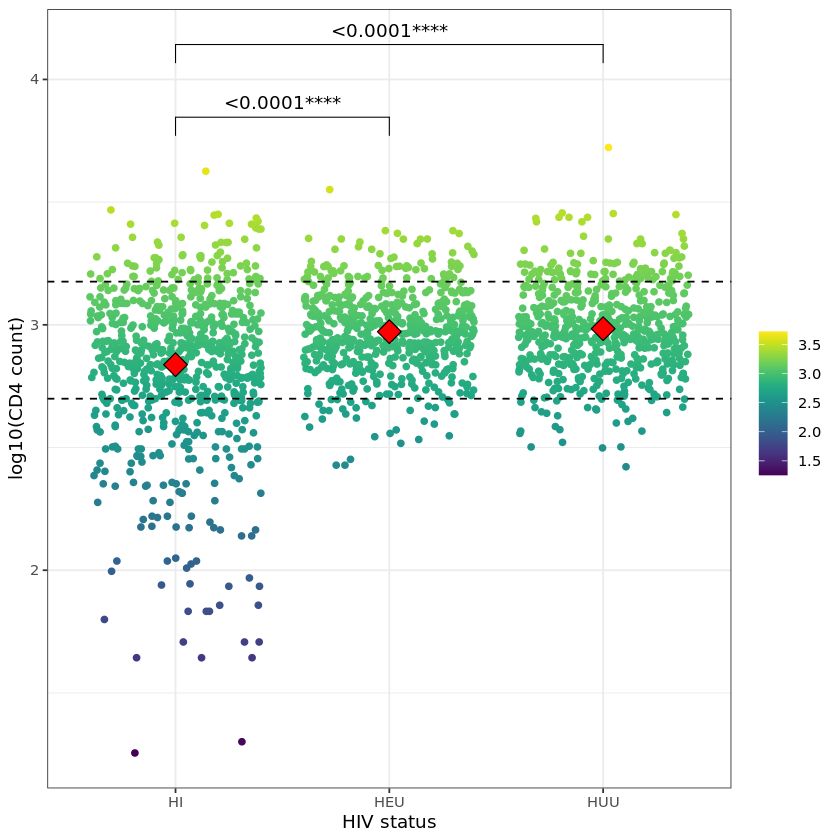

In [3]:
# all samples, split by HIV status, warning messages indicate NA in cd4 counts, can ignore for now
map <- sample_data(ps.dat)
map$hiv_status <- factor(map$hiv_status, levels=c("HI", "HEU", "HUU"))
ggplot(map, aes(x=hiv_status, y=log10(as.integer(cd4_count)))) + 
    geom_point(aes(col=log10(as.integer(cd4_count))), position="jitter") + 
    scale_color_viridis() + 
    theme_bw() +
    geom_hline(yintercept=c(log10(500), log10(1500)), linetype="dashed") +
    geom_pwc(label = "{p.format}{p.signif}", hide.ns =TRUE, p.adjust.method = "fdr") +
    stat_summary(geom = "point", fun = "mean", size = 5, shape = 23, fill = "red") +
    ylab("log10(CD4 count)") +
    xlab("HIV status") +
    theme(legend.title=element_blank())

png 
  2

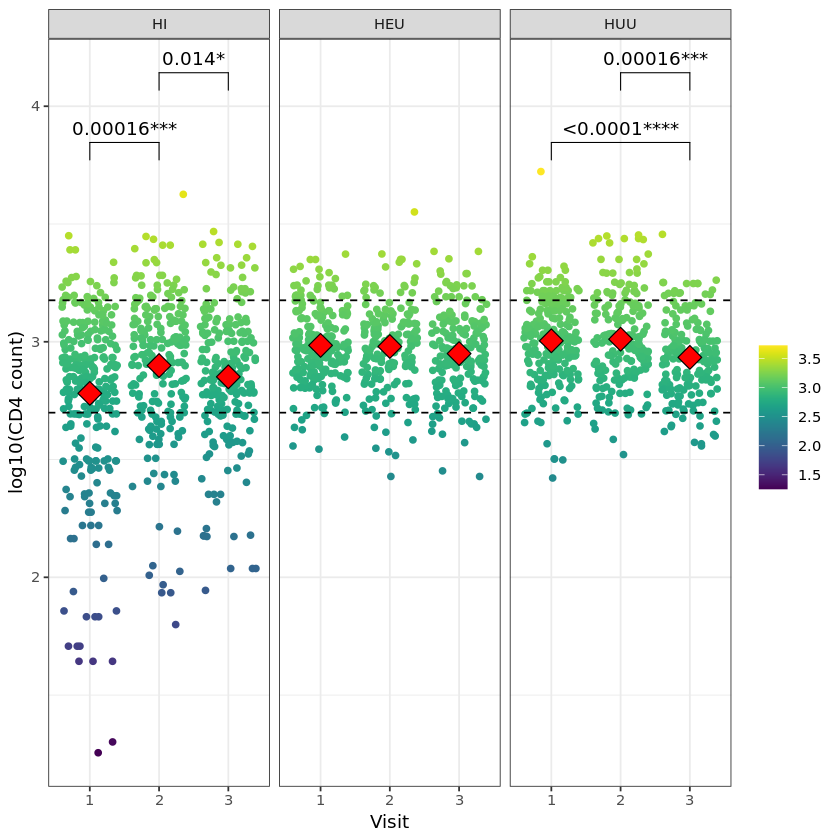

In [4]:
# now want to look at change in CD4 values over the three visits
pdf("cd4_dotplots.pdf")
ggplot(map, aes(x=visit_num, y=log10(as.integer(cd4_count)))) + 
    geom_point(aes(col=log10(as.integer(cd4_count))), position="jitter") + 
    scale_color_viridis() + 
    theme_bw() +
    geom_hline(yintercept=c(log10(500), log10(1500)), linetype="dashed") +
    geom_pwc(label = "{p.format}{p.signif}", hide.ns =TRUE, p.adjust.method = "fdr") +
    stat_summary(geom = "point", fun = "mean", size = 5, shape = 23, fill = "red") +
    ylab("log10(CD4 count)") +
    xlab("Visit") +
    theme(legend.title=element_blank()) +
    facet_grid(cols=vars(hiv_status))
dev.off()
ggplot(map, aes(x=visit_num, y=log10(as.integer(cd4_count)))) + 
    geom_point(aes(col=log10(as.integer(cd4_count))), position="jitter") + 
    scale_color_viridis() + 
    theme_bw() +
    geom_hline(yintercept=c(log10(500), log10(1500)), linetype="dashed") +
    geom_pwc(label = "{p.format}{p.signif}", hide.ns =TRUE, p.adjust.method = "fdr") +
    stat_summary(geom = "point", fun = "mean", size = 5, shape = 23, fill = "red") +
    ylab("log10(CD4 count)") +
    xlab("Visit") +
    theme(legend.title=element_blank()) +
    facet_grid(cols=vars(hiv_status))

## 3. Balance of taxa associated with CD4 counts by HIV status and visit number

Now want to try balance analysis to see which taxa are most influential on CD4 counts. As a note, I'm not including HEU or HUU in this analysis because (1) there isn't a substantial change in CD4 values across the three visits (especially among HEU kids) and (2) taxonomic correlations between HIV groups isn't particularly compelling or informative when previously run using the same scale.

In [5]:
# collapse data to roughly species level to minimize high sparsity
temp <- tax_glom(ps.dat, taxrank=rank_names(ps.dat)[7])
# HI only, filter taxa that aren't found in at least 10% of all samples across visits, and at least 100 reads
temp <- subset_samples(temp, hiv_status == "HI")
temp <- filter_taxa(temp, function(x) sum(x > 100) > (0.1*length(x)), TRUE)
sample_data(temp)$cd4_count <- as.numeric(sample_data(temp)$cd4_count)
temp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 111 taxa and 734 samples ]
sample_data() Sample Data:       [ 734 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 111 tips and 110 internal nodes ]

### Visit one

In [28]:
# save copy to reduce time on previous command
glom <- temp
# visit one first
glom <- subset_samples(glom, visit_num == "1")

In [29]:
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing

In [30]:
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))

In [31]:
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names

In [32]:
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)

[1] 290 110

In [33]:
# define response variable 
y <- as.numeric(datmerge$cd4_count)
length(y)
# some stats
mean(y)
sd(y)

[1] 290

[1] 774.7483

[1] 471.5439

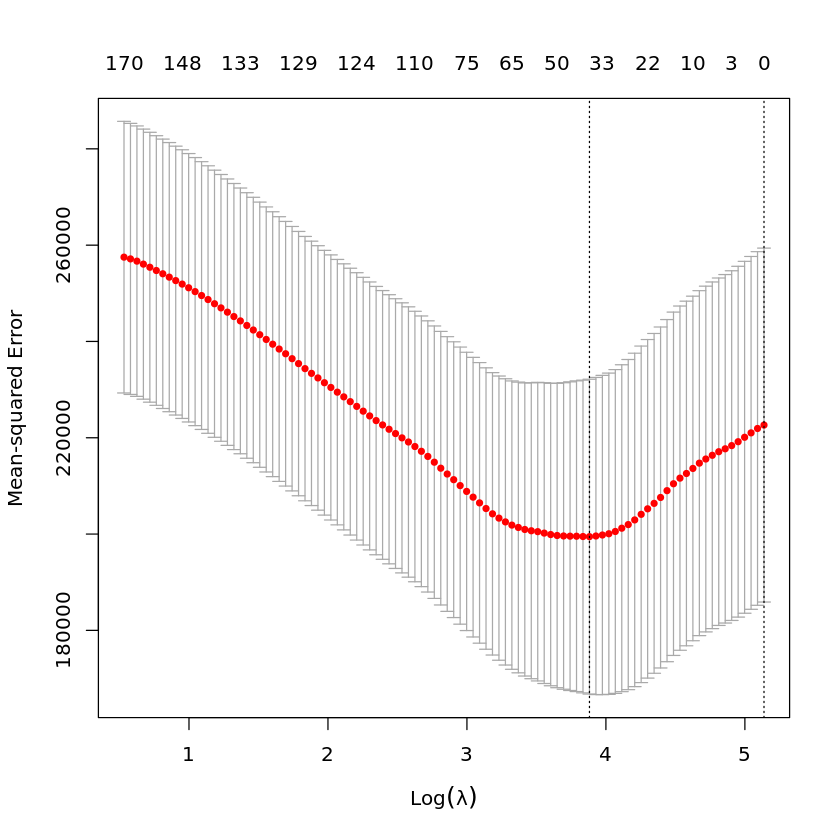

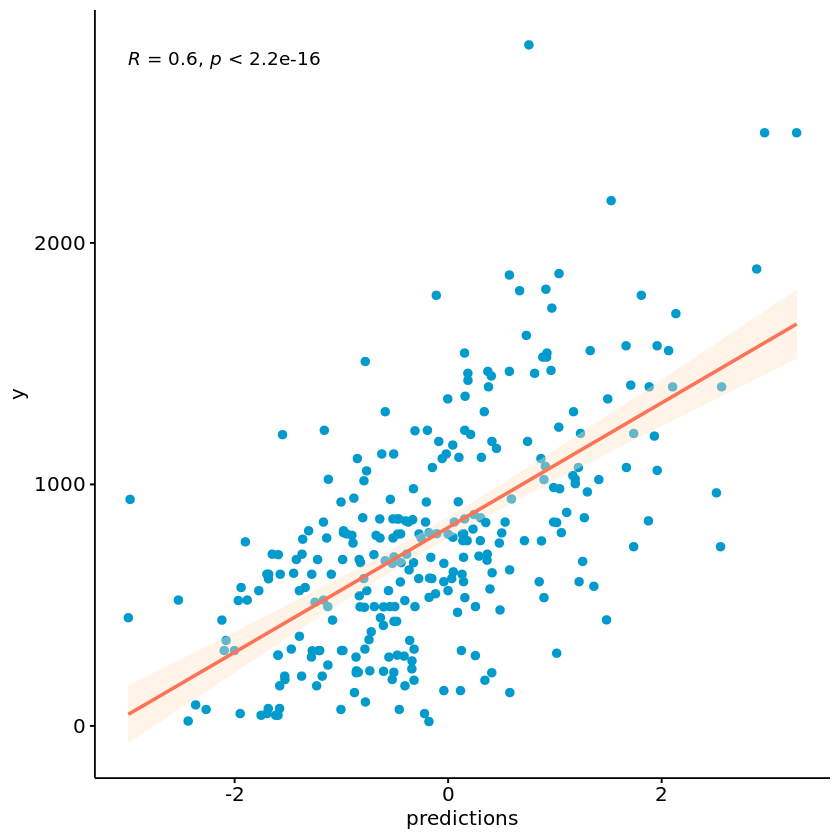

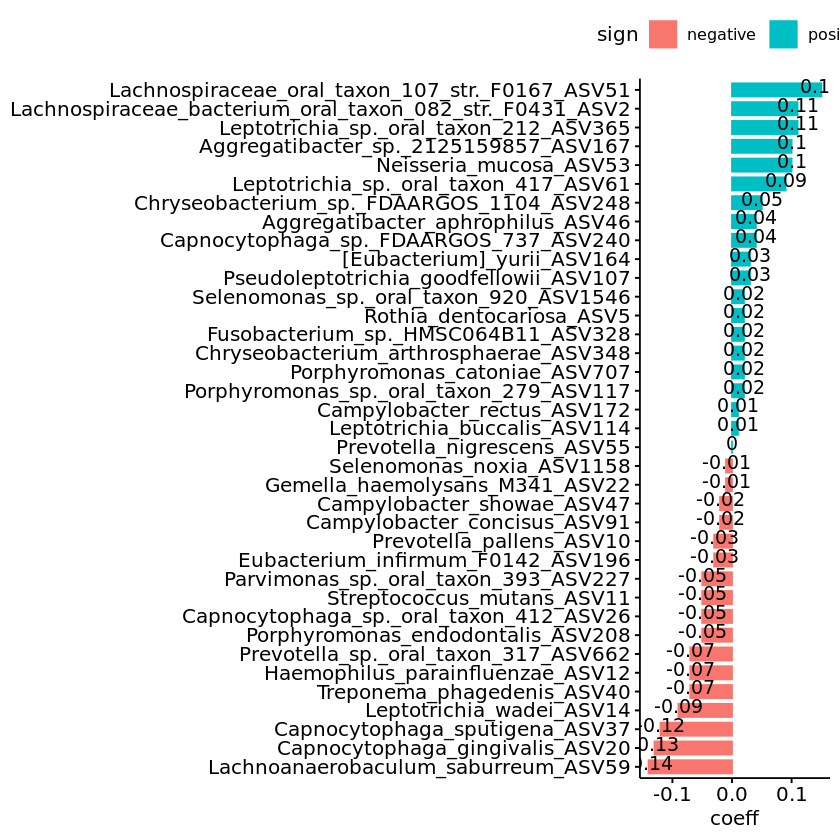

In [34]:
set.seed(852)
bal <- coda_glmnet(x, y, lambda = "lambda.min")

In [35]:
pdf("visit_one_HI_balance.pdf")
bal$`predictions plot`
bal$`signature plot` + ylim(-0.27, 0.45)
dev.off()

png 
  2

png 
  2

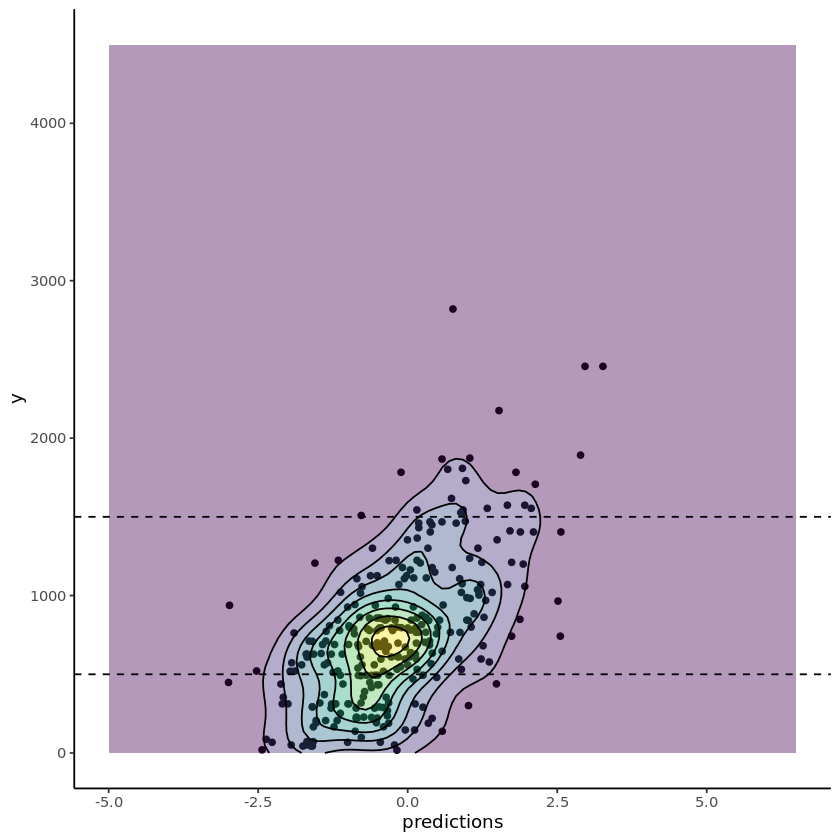

In [36]:
# how to show a shift in distribution of CD4 counts? 
test <- bal$`predictions plot`
ggplot(test$data, aes(x=predictions, y=y)) + 
    geom_point() + 
    geom_density_2d_filled(alpha=0.4) + 
    geom_density_2d(colour="black") +
    theme_classic() +
    geom_hline(yintercept=c(500, 1500), linetype="dashed") +
    ylim(0,4500) +
    xlim(-5,6.5) +
    theme(legend.position="NULL")
pdf("hi_v1_density_plot.pdf")
ggplot(test$data, aes(x=predictions, y=y)) + 
    geom_point() + 
    geom_density_2d_filled(alpha=0.4) + 
    geom_density_2d(colour="black") +
    theme_classic() +
    geom_hline(yintercept=c(500, 1500), linetype="dashed") +
    ylim(0,4500) +
    xlim(-5,6.5) +
    theme(legend.position="NULL")
dev.off()

### Visit two

[1] 216 110

[1] 216

[1] 960.6528

[1] 571.9557

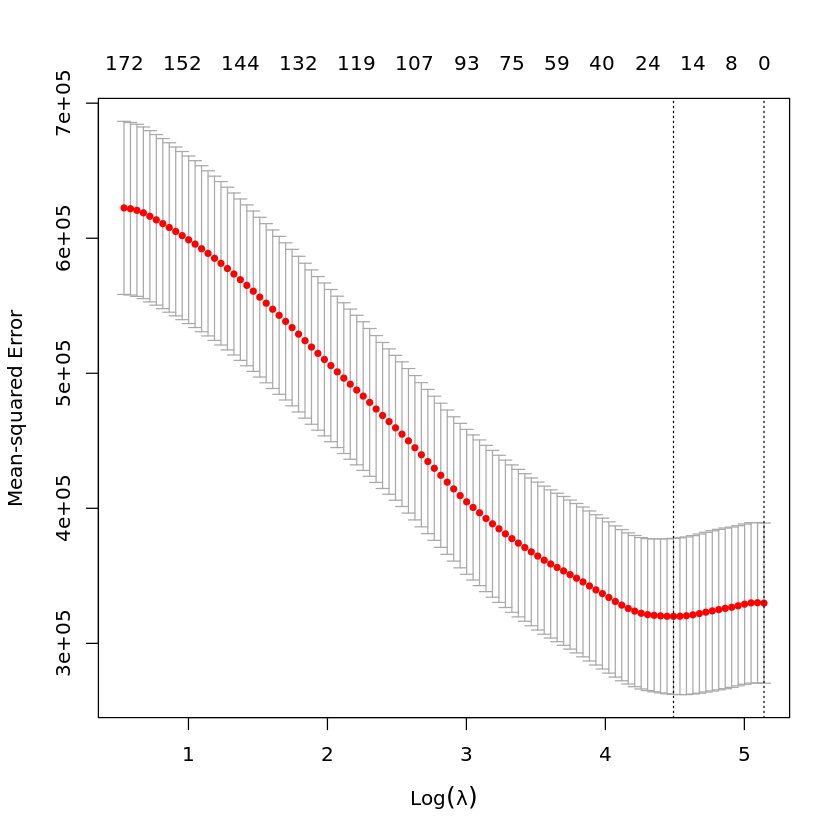

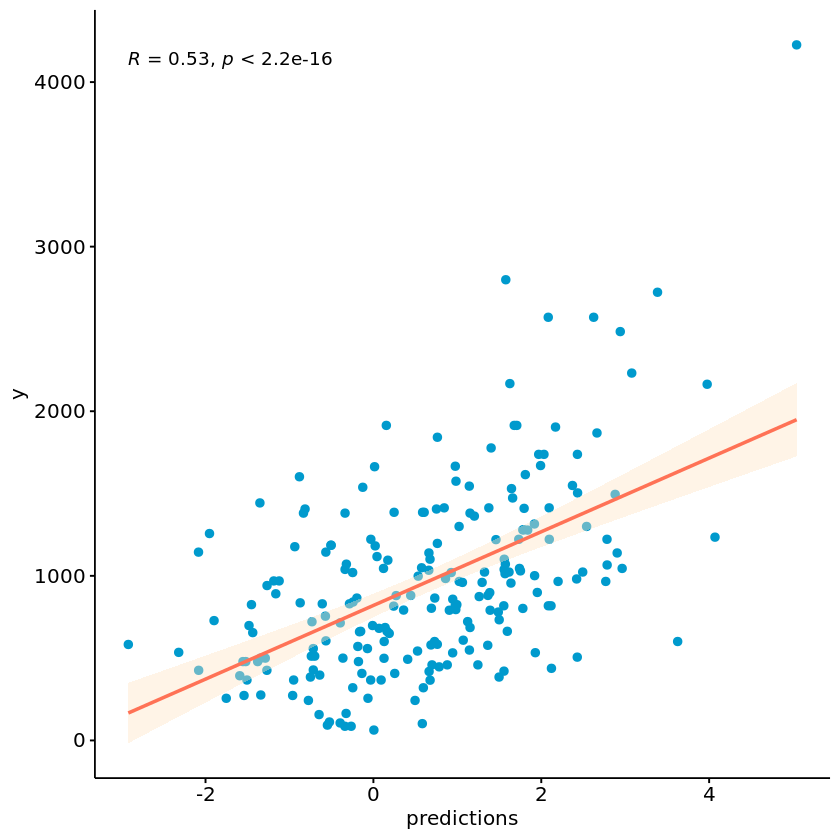

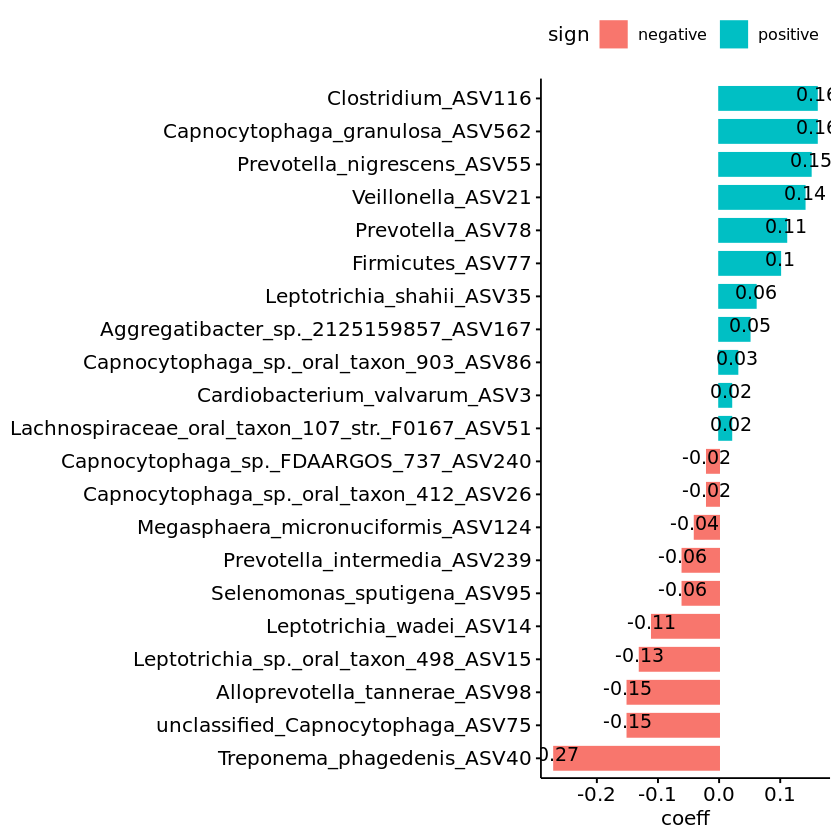

In [37]:
# visit two
glom <- temp
glom <- subset_samples(glom, visit_num == "2")
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.numeric(datmerge$cd4_count)
length(y)
# some stats
mean(y)
sd(y)
bal <- coda_glmnet(x, y, lambda = "lambda.min")

In [38]:
pdf("visit_two_HI_balance.pdf")
bal$`predictions plot`
bal$`signature plot` + ylim(-0.27, 0.45)
dev.off()

png 
  2

png 
  2

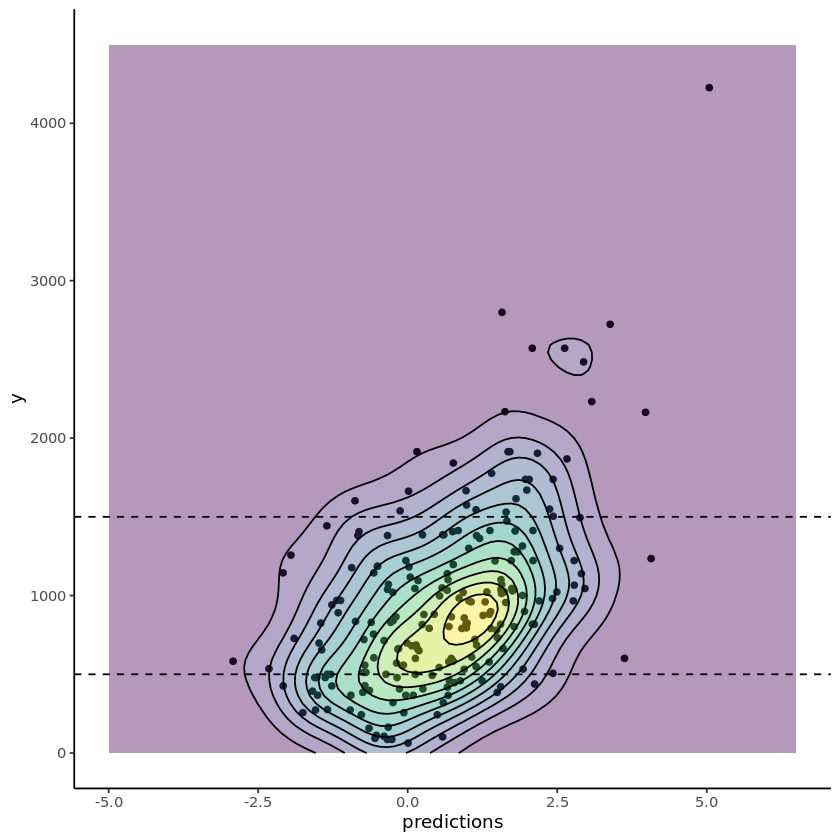

In [39]:
test <- bal$`predictions plot`
ggplot(test$data, aes(x=predictions, y=y)) + 
    geom_point() + 
    geom_density_2d_filled(alpha=0.4) + 
    geom_density_2d(colour="black") +
    theme_classic() +
    geom_hline(yintercept=c(500, 1500), linetype="dashed") +
    ylim(0,4500) +
    xlim(-5,6.5) +
    theme(legend.position="NULL")
pdf("hi_v2_density_plot.pdf")
ggplot(test$data, aes(x=predictions, y=y)) + 
    geom_point() + 
    geom_density_2d_filled(alpha=0.4) + 
    geom_density_2d(colour="black") +
    theme_classic() +
    geom_hline(yintercept=c(500, 1500), linetype="dashed") +
    ylim(0,4500) +
    xlim(-5,6.5) +
    theme(legend.position="NULL")
dev.off()

[1] 228 110

[1] 228

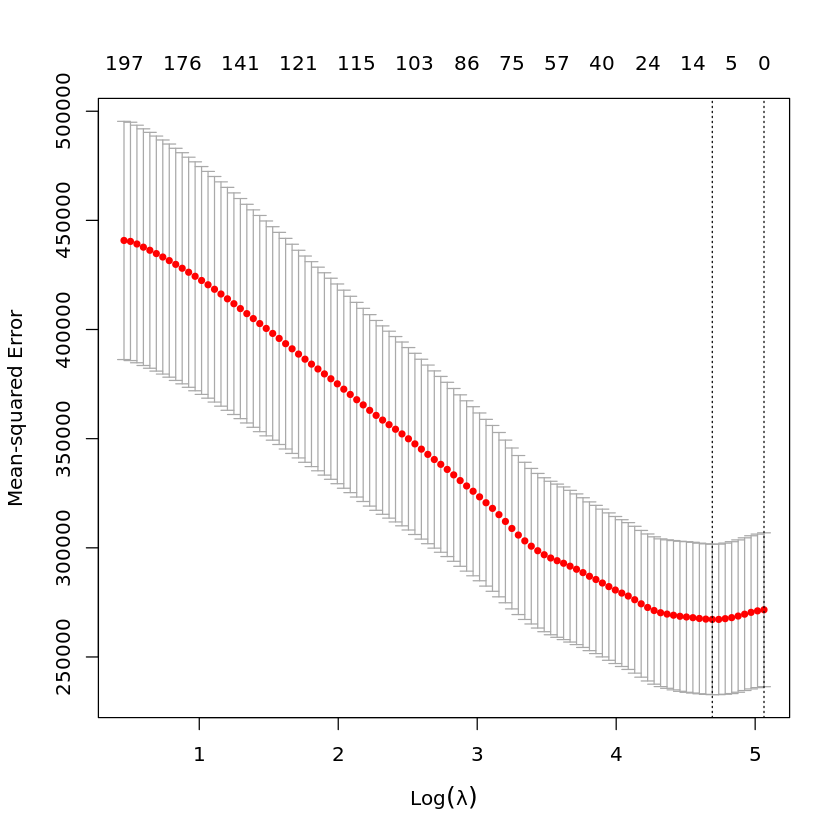

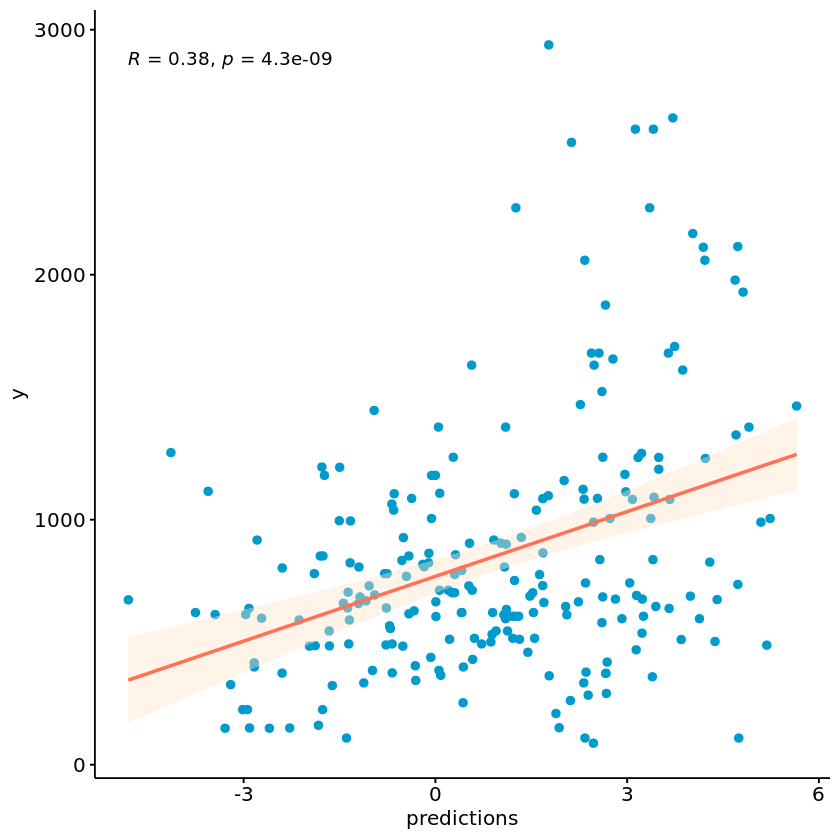

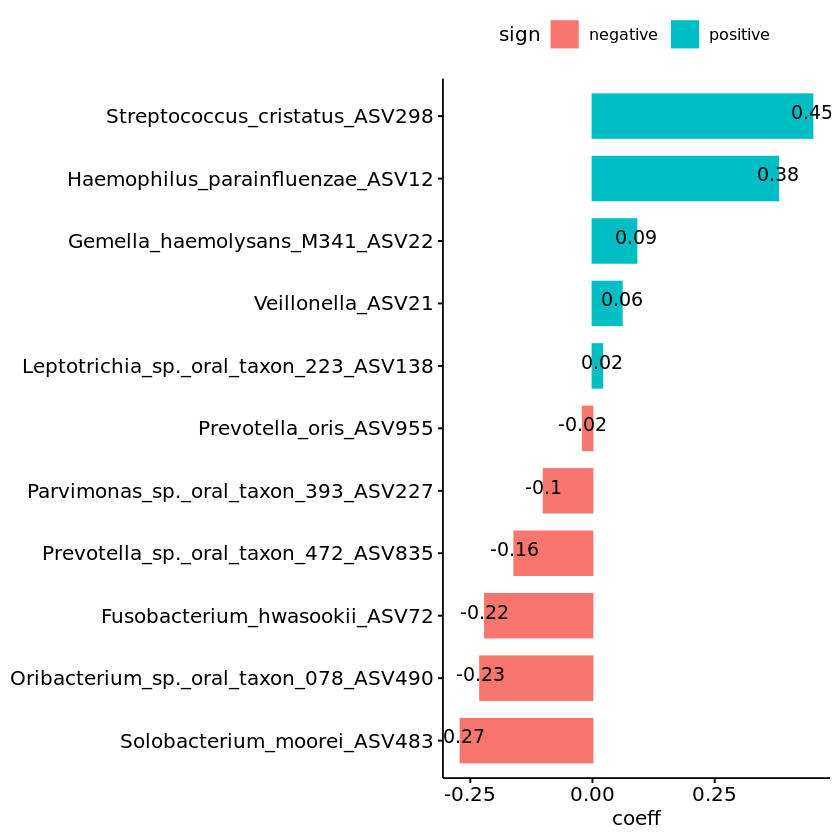

In [40]:
# visit three
glom <- temp
glom <- subset_samples(glom, visit_num == "3")
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.numeric(datmerge$cd4_count)
length(y)
bal <- coda_glmnet(x, y, lambda = "lambda.min")

In [41]:
pdf("visit_three_HI_balance.pdf")
bal$`predictions plot`
bal$`signature plot` + ylim(-0.27, 0.45)
dev.off()

png 
  2

In [42]:
# get some stats about our cd4 analyses
mean(y)
sd(y)

[1] 850.3421

[1] 520.8048

png 
  2

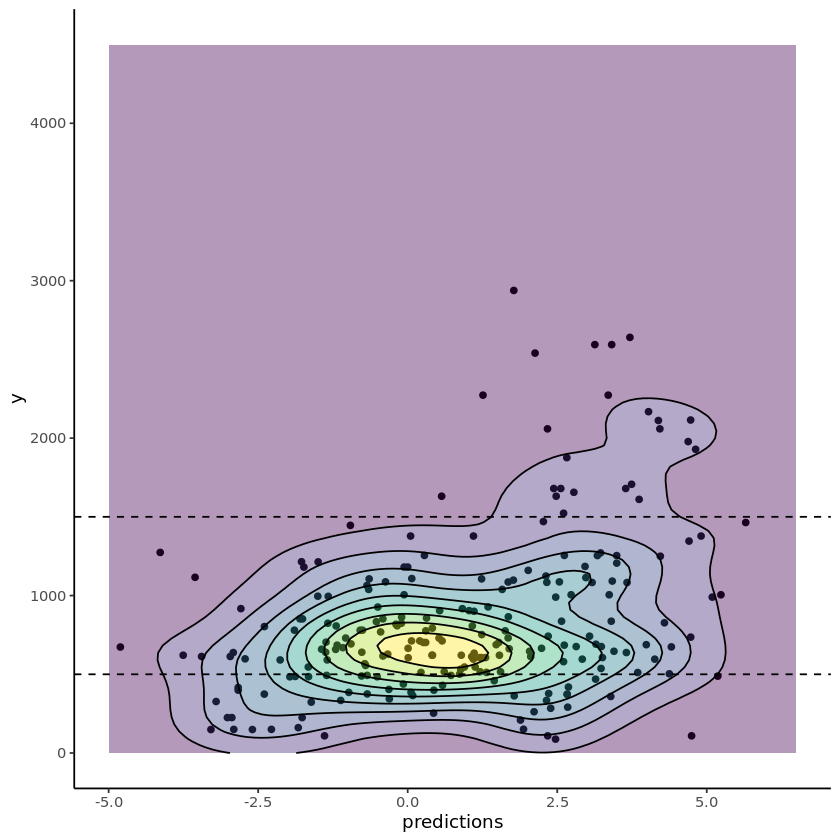

In [43]:
test <- bal$`predictions plot`
ggplot(test$data, aes(x=predictions, y=y)) + 
    geom_point() + 
    geom_density_2d_filled(alpha=0.4) + 
    geom_density_2d(colour="black") +
    theme_classic() +
    geom_hline(yintercept=c(500, 1500), linetype="dashed") +
    ylim(0,4500) +
    xlim(-5,6.5) +
    theme(legend.position="NULL")
pdf("hi_v3_density_plot.pdf")
ggplot(test$data, aes(x=predictions, y=y)) + 
    geom_point() + 
    geom_density_2d_filled(alpha=0.4) + 
    geom_density_2d(colour="black") +
    theme_classic() +
    geom_hline(yintercept=c(500, 1500), linetype="dashed") +
    ylim(0,4500) +
    xlim(-5,6.5) +
    theme(legend.position="NULL")
dev.off()

In [44]:
# is alpha diversity correlated with CD4 count?

In [45]:
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1958 samples ]
sample_data() Sample Data:       [ 1958 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

In [46]:
sub <- subset_samples(ps.dat, hiv_status == "HI")
adiv <- estimate_richness(sub)

In [47]:
adiv.map <- transform(merge(sample_data(sub), adiv, by=0), row.names=Row.names, Row.names=NULL)

In [48]:
head(adiv.map)
adiv.map$cd4_count <- as.numeric(adiv.map$cd4_count)
adiv.map$cd4_log <- log10(adiv.map$cd4_count)

,DNA_ng.ul,rpoC_amplicon_count,study_id,cd4_count,cd4_group,FDI_code,tooth_type,tooth_age,tooth_location,visit_num,⋯,file_R2,Observed,Chao1,se.chao1,ACE,se.ACE,Shannon,Simpson,InvSimpson,Fisher
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DM00001V1PQ,unknown,12763,DM00001,638,normal,unknown,NA,NA,NA,1,⋯,DM00001V1PQ_S1_L001_R2_001.fastq.gz,125,125,0.4979960,125.1658,4.376211,3.712815,0.9486835,19.486925,19.32543
DM00001V2PQ16,4.36,37640,DM00001,1504,high,16,molar,adult,upper_right,2,⋯,DM00001V2PQ16_S31_L001_R2_001.fastq.gz,113,113,0.2488913,113.1854,4.252901,3.304656,0.9181053,12.210808,15.02191
DM00003V3PQ16,unknown,26448,DM00003,1255,normal,16,molar,adult,upper_right,3,⋯,DM00003V3PQ16_S10_L001_R2_001.fastq.gz,136,136,0.4981584,136.1639,4.093170,3.860396,0.9629714,27.006170,18.94984
DM00003V3PQ55,unknown,15840,DM00003,1255,normal,55,premolar,deciduous,upper_right,3,⋯,DM00003V3PQ55_S11_L001_R2_001.fastq.gz,109,109,0.0000000,109.0000,3.493112,3.213316,0.8760959,8.070756,15.89161
DM00004V3PQ16,unknown,21425,DM00004,419,low,16,molar,adult,upper_right,3,⋯,DM00004V3PQ16_S12_L001_R2_001.fastq.gz,79,79,0.0000000,79.0000,3.295567,2.973793,0.9174537,12.114415,10.46439
DM00006V1PQ1,5.16,18441,DM00006,519,normal,unknown,unknown,unknown,unknown,1,⋯,DM00006V1PQ1_S7_L001_R2_001.fastq.gz,165,165,0.0000000,165.0000,4.366539,4.319828,0.9779031,45.255312,25.03796


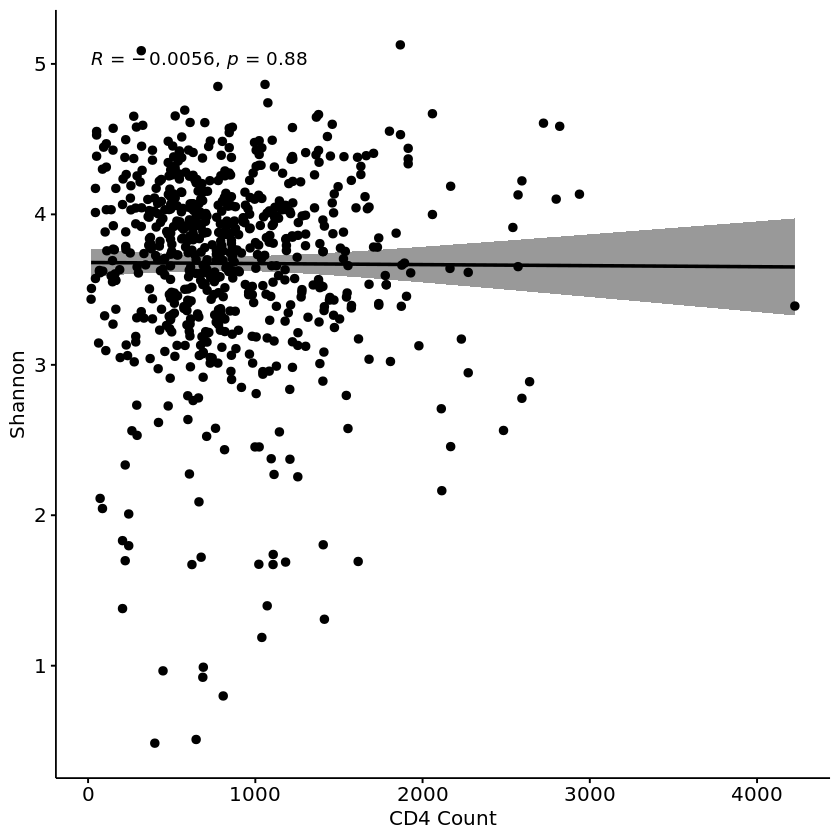

In [49]:
library(ggpubr)
adiv.map <- na.omit(adiv.map)
ggscatter(adiv.map, x = "cd4_count", y = "Shannon", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson",
          xlab = "CD4 Count", ylab = "Shannon")

In [53]:
# how many of each tooth group do we have from each visit?
# NOTE: this is excluding two samples with no CD4 count (unknown samples filtered out earlier). Not including them since they are not represented in the other figures
# first filter so we're only looking at HI kids
sub <- subset_samples(ps.dat, hiv_status == "HI")
sub

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 734 samples ]
sample_data() Sample Data:       [ 734 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

In [81]:
# now by visit, how many of each oral health category?
# start with visit one
sub2 <- subset_samples(sub, visit_num == "1")
oral_health <- unique(as.data.frame(cbind(sample_data(sub2)$study_id, sample_data(sub2)$oral_health)))
colnames(oral_health) <- c("study_id", "oral_health")
count(oral_health, oral_health)

oral_health,n
<chr>,<int>
CD,44
CE,16
CF,107


In [83]:
# visit two
sub2 <- subset_samples(sub, visit_num == "2")
oral_health <- unique(as.data.frame(cbind(sample_data(sub2)$study_id, sample_data(sub2)$oral_health)))
colnames(oral_health) <- c("study_id", "oral_health")
count(oral_health, oral_health)

oral_health,n
<chr>,<int>
CD,35
CE,12
CF,111


In [84]:
# visit three
sub2 <- subset_samples(sub, visit_num == "3")
oral_health <- unique(as.data.frame(cbind(sample_data(sub2)$study_id, sample_data(sub2)$oral_health)))
colnames(oral_health) <- c("study_id", "oral_health")
count(oral_health, oral_health)

oral_health,n
<chr>,<int>
CD,35
CE,20
CF,110
